## NR/AE Denoised NR - SLD - CNN Prediction

### Install package

In [ ]:
!pip uninstall -y pyreflect

In [ ]:
!pip install -i https://test.pypi.org/simple/ pyreflect==1.2.9

In [ ]:
!pip show pyreflect

In [2]:
!python -m pyreflect init --force

Selected device for model training: cuda
Initialized settings file at /home/qiao.yuqi/NR-SCFT-ML/pyreflect/settings.yml.


In [30]:
import pyreflect
from pyreflect.config import load_config
import pyreflect.flows.nr_predict_sld as workflow
from pyreflect.input import NRSLDDataProcessor

import pandas as pd
from pathlib import Path
from pprint import pprint

from typing import List
import numpy as np

In [31]:
#load config
root = "./"
# root = Path("./")

config = pyreflect.config.load_config(root)
pprint(config["nr_predict_sld"])

{'file': {'experimental_nr_file': 'data/curves/experimental_nr_curves.npy',
          'nr_curves_poly': 'data/curves/nr_curves_poly.npy',
          'reflectivity_model_bounds': 'data/curves/reflectivity_model_bounds.json',
          'sld_curves_poly': 'data/curves/sld_curves_poly.npy'},
 'models': {'batch_size': 32,
            'epochs': 10,
            'model': 'data/trained_nr_sld_model.pth',
            'normalization_stats': 'data/normalization_stat.npy',
            'num_curves': 50000,
            'num_film_layers': 5}}


### Load NR SLD profile before reconstruction

In [32]:
orig_nr_file = "./data/curves/orig_tr_nr.npy"
orig_sld_file = "./data/curves/orig_tr_sld.npy"

dproc = NRSLDDataProcessor(orig_nr_file,orig_sld_file).load_data()
dproc._nr_arr.shape, dproc._sld_arr.shape

((70000, 2, 308), (70000, 2, 900))

In [33]:
import matplotlib.pyplot as plt

def plot_experiment_results(expt_nr_data,expt_sld_data,orig_nr_data=None,predicted_sld=None):
    """
    Plots experimental NR data separately and overlays experimental SLD with predicted SLD if available.

    Parameters:
        expt_nr_data (np.ndarray): Experimental Neutron Reflectivity data, shape (2, *).
        predicted_sld (np.ndarray): Predicted SLD profile, shape (2, *).
        expt_sld_data (np.ndarray, optional): Experimental SLD profile, shape (2, *). Default is None.

    Notes:
        - expt_nr_data[0] is Q (wave vector), expt_nr_data[1] is Reflectivity.
        - predicted_sld[0] is Depth (Å), predicted_sld[1] is SLD values.
        - expt_sld_data is only plotted if provided.
    """

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Two side-by-side plots

    # Left Plot: Experimental NR (Reflectivity vs. Q)
    
    axes[0].plot(expt_nr_data[0], expt_nr_data[1], 'b-', label="AE Denoised NR", alpha=0.7)
    if orig_nr_data is not None:
        axes[0].plot(orig_nr_data[0], orig_nr_data[1], 'g--', label="Original NR", linewidth=2)
    
    axes[0].set_xlabel("Q (1/Å)")  # Wave vector transfer
    axes[0].set_ylabel("Reflectivity", color="blue")
    axes[0].set_yscale("log")  # Reflectivity is usually in log scale
    axes[0].set_title("Experimental NR Data")
    axes[0].legend()

    # Right Plot: Predicted SLD vs. Experimental SLD (if available)
    axes[1].plot(expt_sld_data[0], expt_sld_data[1], 'r-', label="Original SLD", linewidth=2)
    
    if predicted_sld is not None:
        axes[1].plot(predicted_sld[0], predicted_sld[1], 'g--', label="Predicted SLD", linewidth=2)
    
    axes[1].set_xlabel("Depth (Å)")
    axes[1].set_ylabel("Scattering Length Density (SLD) [10⁻⁶ Å⁻²]")
    axes[1].set_title("SLD Profiles")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


### Model Training and Prediction

In [34]:
from pyreflect.models.config import NRSLDModelTrainerParams
import pyreflect.flows.nr_predict_sld as workflow

file_config = config["nr_predict_sld"]["file"]
model_config = config["nr_predict_sld"]["models"]

In [35]:
#use AE reconstructed NR SLD to train model
file_config["nr_curves_poly"] = orig_nr_file
file_config["sld_curves_poly"] = orig_sld_file
model_config["epochs"]= 10
model_config["num_film_layers"]=5
# config["root"] = "./"
file_config, model_config

({'experimental_nr_file': 'data/curves/experimental_nr_curves.npy',
  'nr_curves_poly': './data/curves/orig_tr_nr.npy',
  'sld_curves_poly': './data/curves/orig_tr_sld.npy',
  'reflectivity_model_bounds': 'data/curves/reflectivity_model_bounds.json'},
 {'model': 'data/trained_nr_sld_model.pth',
  'num_film_layers': 5,
  'num_curves': 50000,
  'epochs': 10,
  'batch_size': 32,
  'normalization_stats': 'data/normalization_stat.npy'})

In [36]:
trainer_params = NRSLDModelTrainerParams(root,_config = config)

X,y = workflow.preprocess(dproc,trainer_params.normalization_stats)

model = workflow.train_nr_predict_sld_model(X,y,trainer_params,auto_save=True)

Epoch 1/10 - Train Loss: 0.007309, Validation Loss: 0.006975
Epoch 2/10 - Train Loss: 0.004391, Validation Loss: 0.004480
Epoch 3/10 - Train Loss: 0.003425, Validation Loss: 0.002771
Epoch 4/10 - Train Loss: 0.003049, Validation Loss: 0.002654
Epoch 5/10 - Train Loss: 0.002841, Validation Loss: 0.002095
Epoch 6/10 - Train Loss: 0.002677, Validation Loss: 0.001929
Epoch 7/10 - Train Loss: 0.002560, Validation Loss: 0.001915
Epoch 8/10 - Train Loss: 0.002479, Validation Loss: 0.001949
Epoch 9/10 - Train Loss: 0.002395, Validation Loss: 0.001814
Epoch 10/10 - Train Loss: 0.002334, Validation Loss: 0.001674
NR predict SLD trained CNN model saved at: data/trained_nr_sld_model.pth


In [8]:
# model_path = 'data/trained_nr_sld_model.pth'
# model = workflow.load_nr_sld_model(model_path)

model = workflow.load_nr_sld_model(model_config["model"])

In [37]:
normalization_stats = model_config["normalization_stats"]
# load the min max normalization scaler during training
tr_norm_stats = workflow.load_normalization_stat(normalization_stats)
tr_norm_stats

{'nr': {'x': {'min': np.float32(0.008101436), 'max': np.float32(0.1975709)},
  'y': {'min': np.float32(-8.000001), 'max': np.float32(0.0)}},
 'sld': {'x': {'min': np.float32(0.0), 'max': np.float32(932.1)},
  'y': {'min': np.float32(0.0010511698), 'max': np.float32(4.952561)}}}

In [ ]:
test_nr_file = "./data/curves/orig_tst_nr.npy"
y_pred = workflow.predict_sld_from_nr(model, test_nr_file,norm_stats)

## Plot SLD prediction previews

In [14]:
#load test data for ploting
tst_nr_file = "./data/curves/orig_tst_nr.npy"
tst_sld_file = "./data/curves/orig_tst_sld.npy"

tst_dproc = NRSLDDataProcessor(tst_nr_file,tst_sld_file).load_data()

# tst_nr_arr = tst_dproc.normalize_nr()
# tst_sld_arr = tst_dproc.normalize_sld()

tst_dproc._nr_arr.shape,tst_dproc._sld_arr.shape

((15000, 2, 308), (15000, 2, 900))

### Plotting Prediction
 - Non denoised AE NR

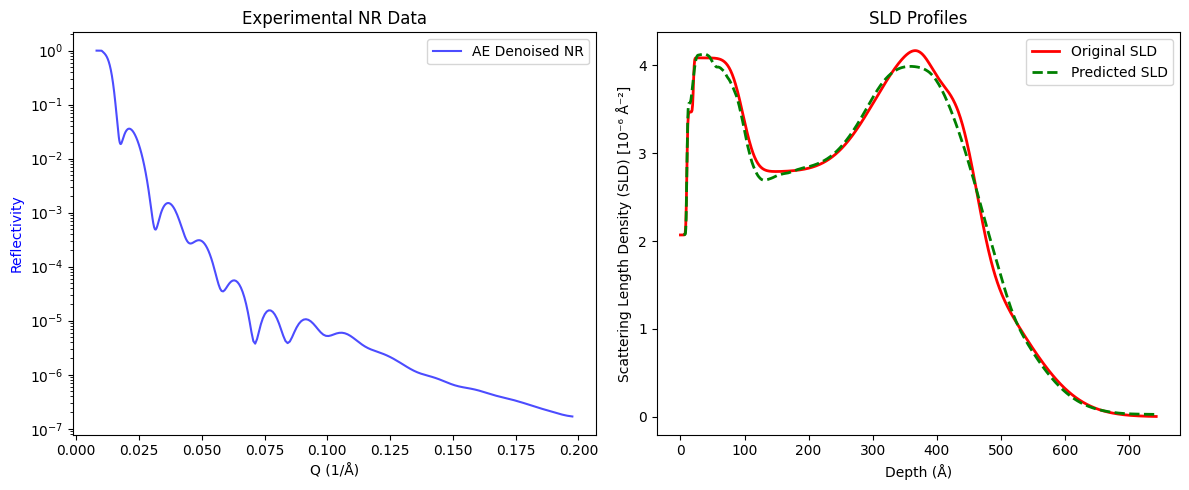

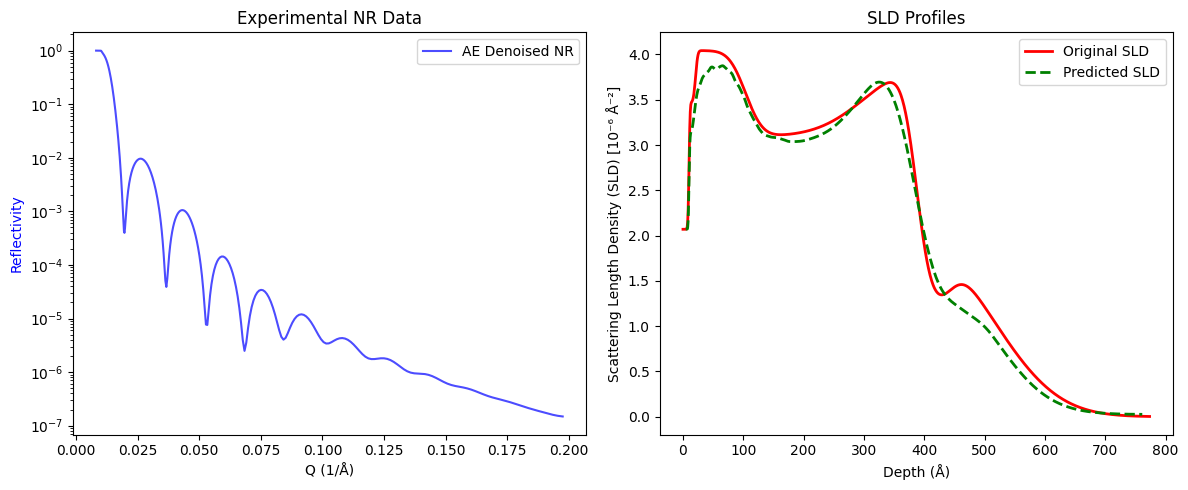

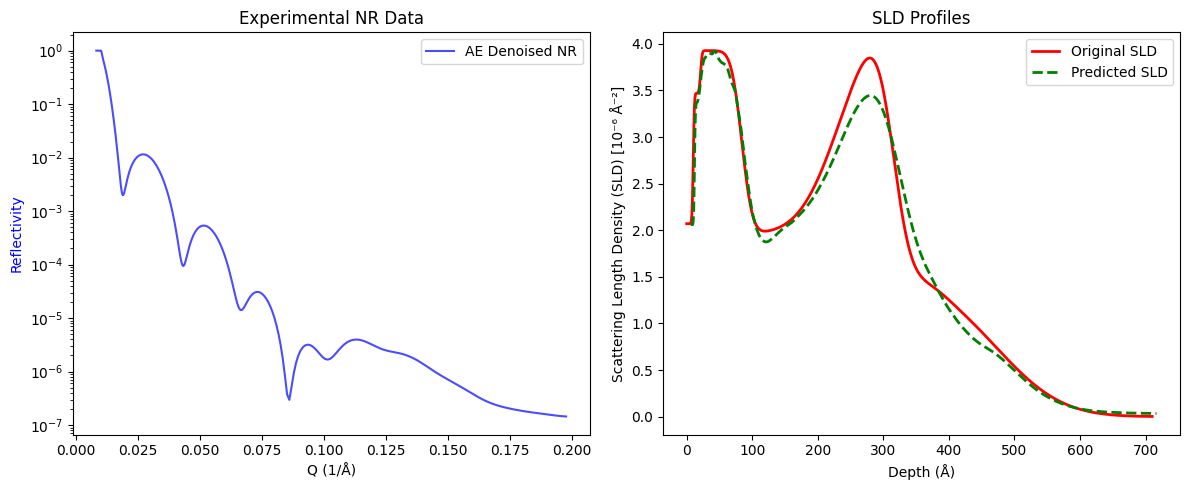

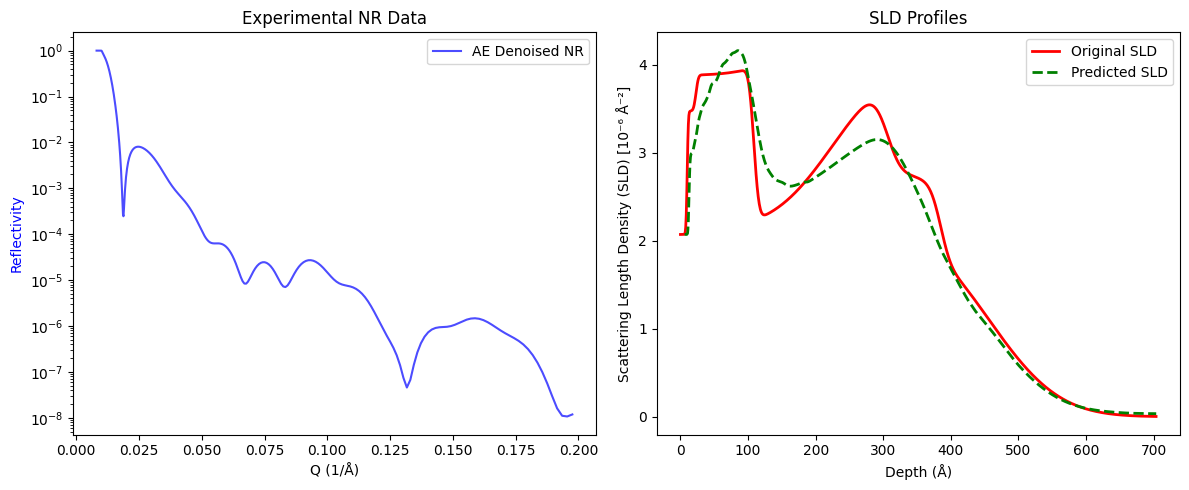

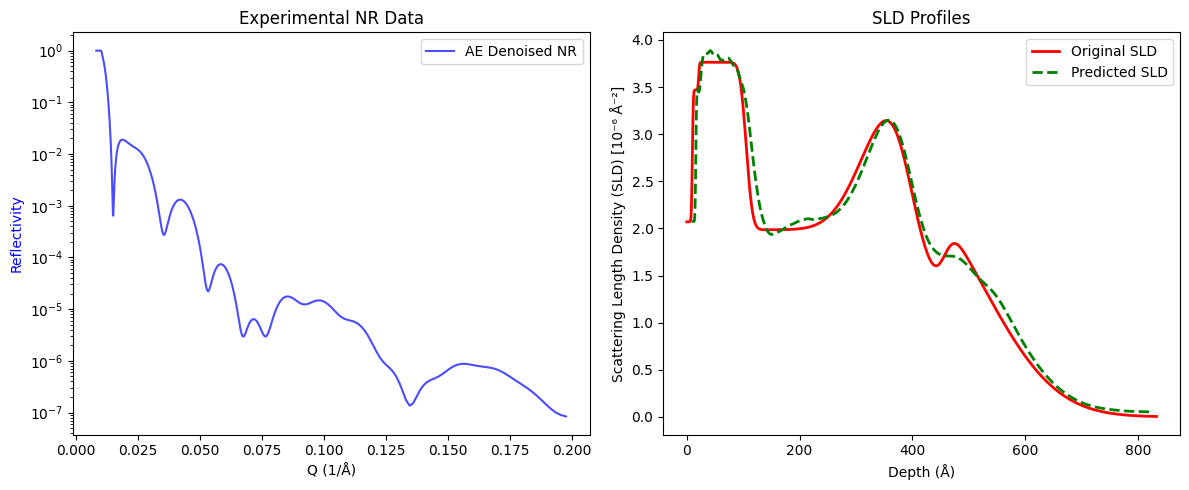

In [15]:
x_tst = tst_dproc._nr_arr
y_tst = tst_dproc._sld_arr
for x, y, sld_y_pred in zip(x_tst[-5:], y_tst[-5:], y_pred[-5:]):
    plot_experiment_results(x,y,predicted_sld=sld_y_pred)


### Result - MSE, R2 - CNN - Pure NR

In [17]:
import torch
import torch.nn.functional as F

# Convert to torch tensors
y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
y_tst_tensor = torch.tensor(y_tst, dtype=torch.float32)

# Calculate MSE
mse = F.mse_loss(y_pred_tensor, y_tst_tensor)
normalized_mse = mse / np.var(y_tst)

print("MSE:", mse.item())
print("normalized MSE:", normalized_mse.item())


from sklearn.metrics import r2_score
import numpy as np

# Assume y_pred and y_tst are both numpy arrays with shape [batch, 2, features]
# Flatten both to 1D
y_pred_flat = y_pred.reshape(-1)
y_tst_flat = y_tst.reshape(-1)

# Compute R² score
r2 = r2_score(y_tst_flat, y_pred_flat)

print(f"R² Score: {r2:.4f}")

print(f"y pred shape: {y_pred.shape}")

MSE: 193.30059814453125
normalized MSE: 0.003542910795658827
R² Score: 0.9965
y pred shape: (15000, 2, 900)


### Load AE Denoised NR, SLD profile Data

In [20]:
model = workflow.load_nr_sld_model("./data/trained_nr_sld_model.pth")

In [41]:
denoised_nr_file = "./data/curves/expt/combined_expt_denoised_nr.npy"
y_pred_denoised = workflow.predict_sld_from_nr(model, denoised_nr_file,tr_norm_stats)

Predicted SLD shape: (8, 2, 900)


In [78]:
# Experimental NR data

expt_nr_file = "./data/curves/expt/combined_nr.npy"

expt_sld_file = "./data/curves/expt/combined_sld.npy"

# Data processor
# expt_dproc = NRSLDDataProcessor(nr_file_path=expt_nr_file,sld_file_path=expt_sld_file).load_data()

expt_nr_arr = np.load(expt_nr_file, allow_pickle=True)
expt_sld_arr = np.load(expt_sld_file,allow_pickle=True)


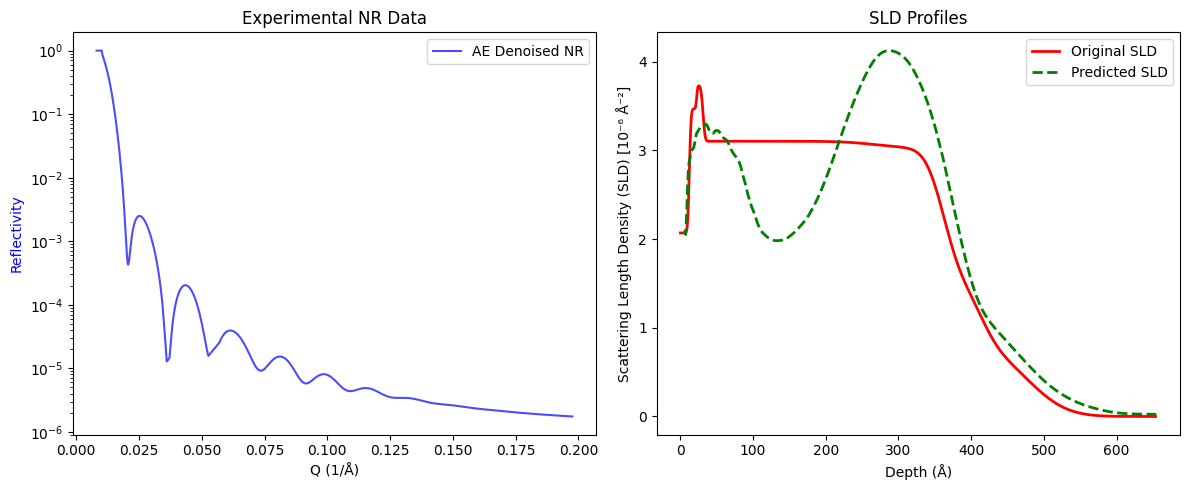

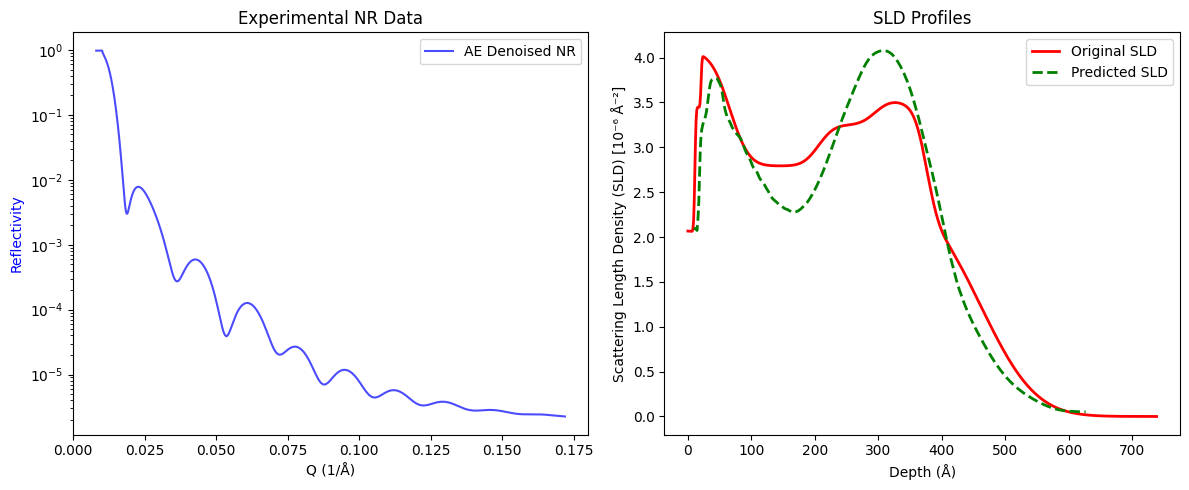

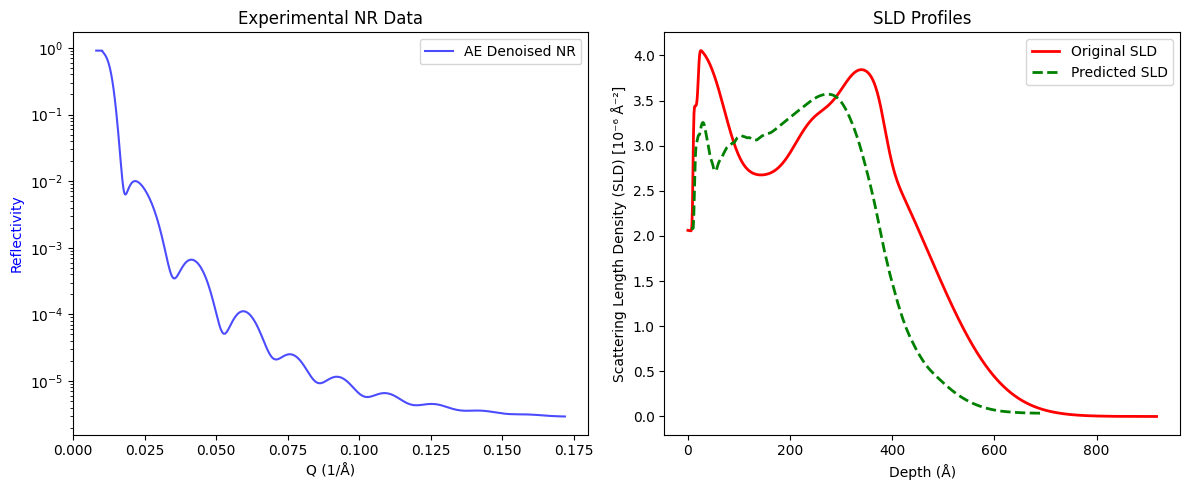

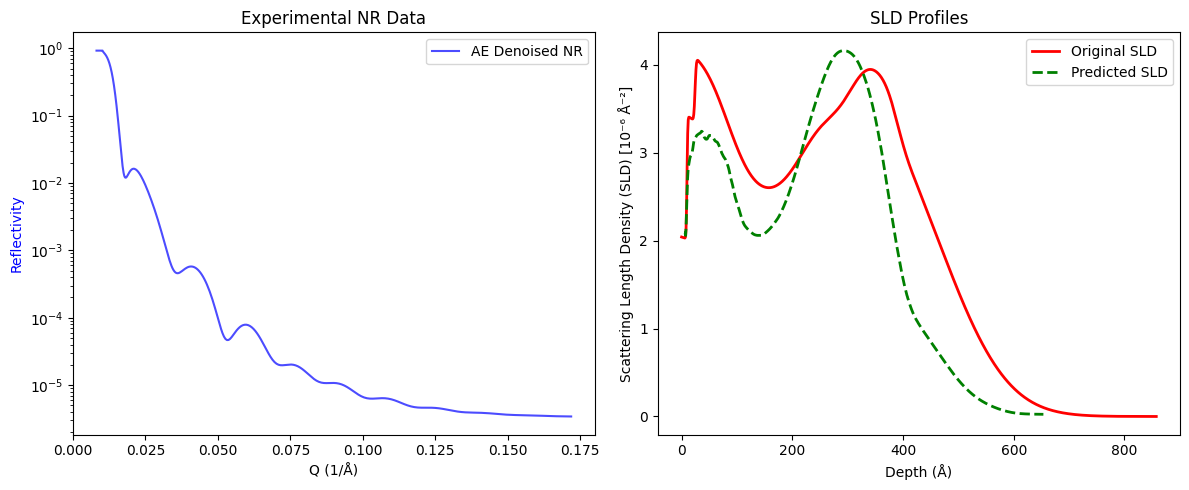

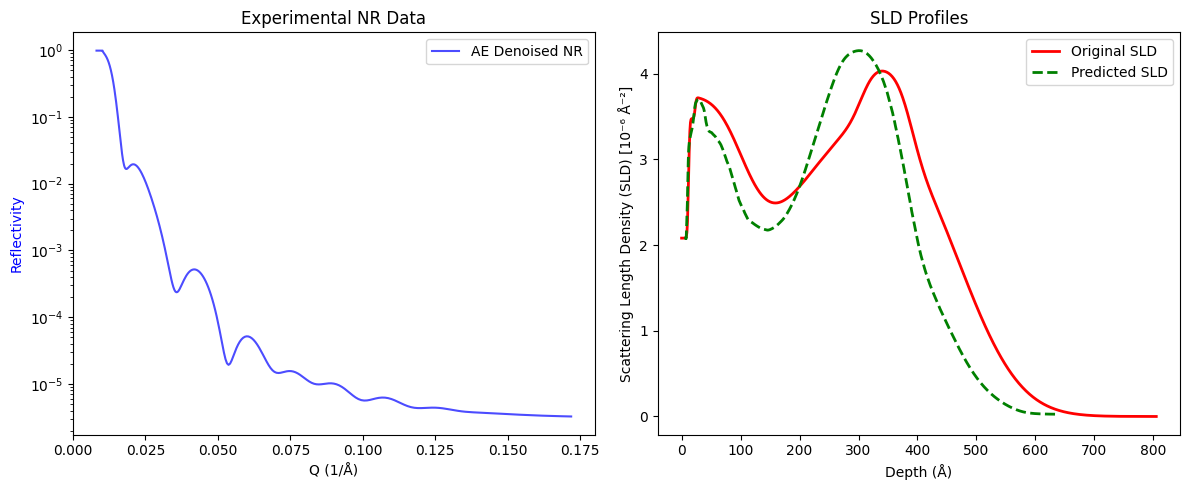

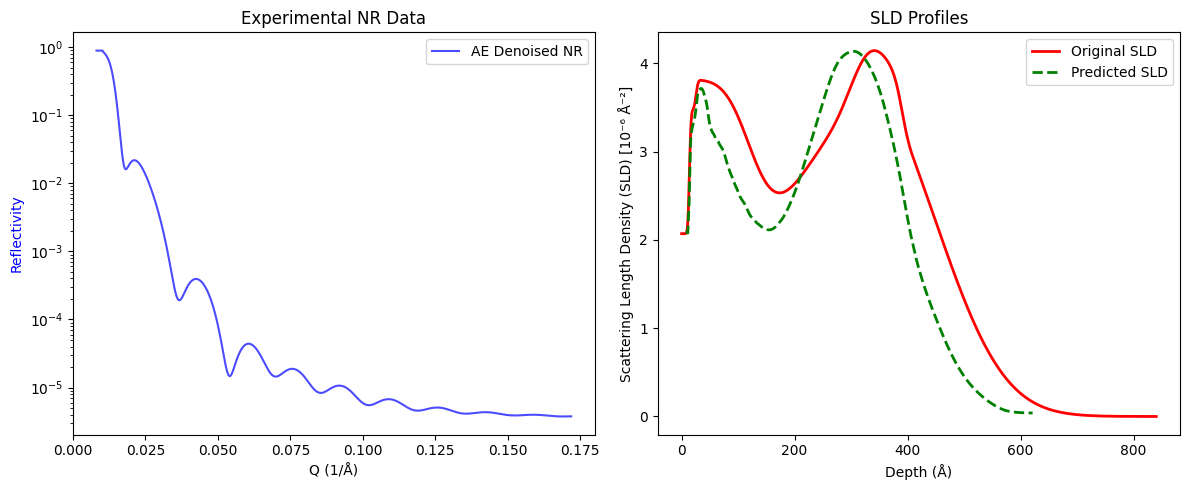

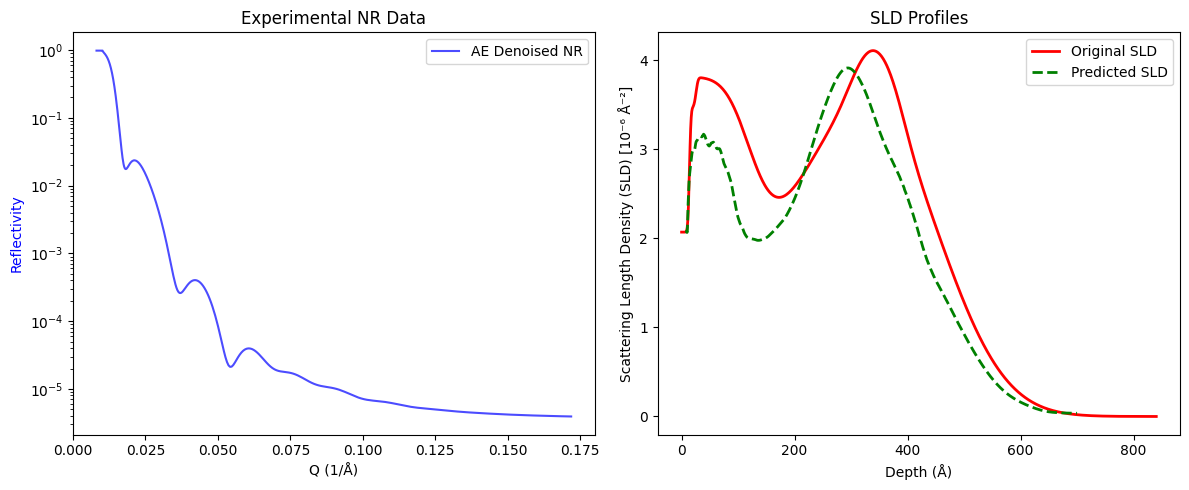

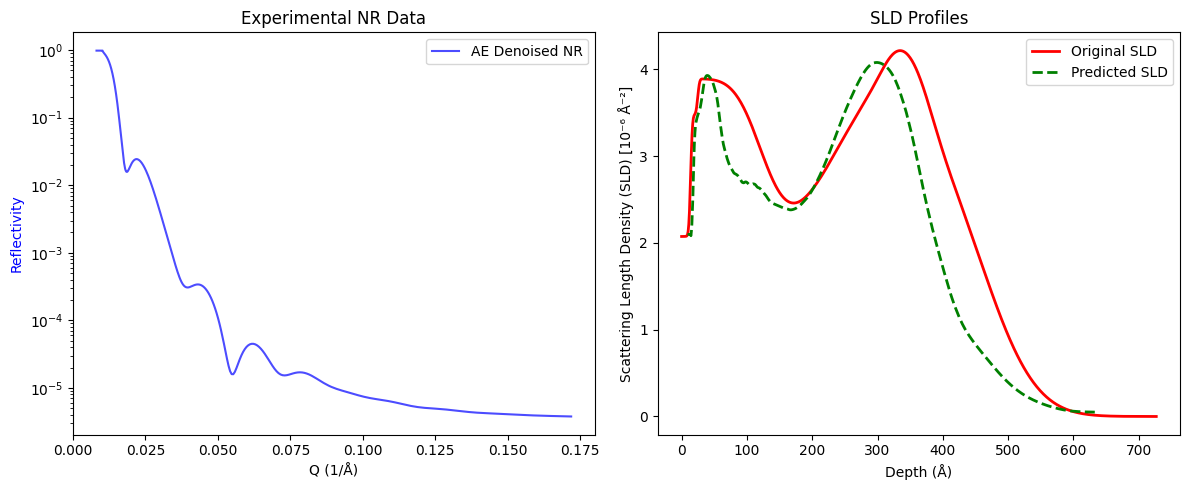

In [79]:
for expt_nr, expt_sld, y in zip(expt_nr_arr,expt_sld_arr,y_pred_denoised):
    plot_experiment_results(expt_nr,expt_sld,predicted_sld=y)